# Mesa Schelling example - Schelling Segregation Model

[[Code explanation]](https://towardsdatascience.com/introduction-to-mesa-agent-based-modeling-in-python-bcb0596e1c9a) **Note that the final interactive visualization part we will cover in the later parts of the course**

## Background

The Schelling (1971) segregation model is a classic of agent-based modeling, demonstrating how agents following simple rules lead to the emergence of qualitatively different macro-level outcomes. Agents are randomly placed on a grid. There are two types of agents, one constituting the majority and the other the minority. All agents want a certain number (generally, 3) of their 8 surrounding neighbors to be of the same type in order for them to be happy. Unhappy agents will move to a random available grid space. While individual agents do not have a preference for a segregated outcome (e.g. they would be happy with 3 similar neighbors and 5 different ones), the aggregate outcome is nevertheless heavily segregated.

In [1]:
import random

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid
from mesa.datacollection import DataCollector

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Agent

class SchellingAgent(Agent):
    '''
    Schelling segregation agent
    '''
    
    # 1 Initialization
    def __init__(self, pos, model, agent_type):
        '''
         Create a new Schelling agent.

         Args:
            unique_id: Unique identifier for the agent.
            x, y: Agent initial location.
            agent_type: Indicator for the agent's type (minority=1, majority=0)
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.type = agent_type

    # 2 Step function
    def step(self):
        similar = 0
        neighbors = self.model.grid.neighbor_iter(self.pos)
        
        # 3 Calculate the number of similar neighbours
        for neighbor in neighbors:
            if neighbor.type == self.type:
                similar += 1

        # 4 Move to a random empty location if unhappy
        if similar/len(self.model.grid.get_neighbors(self.pos, True)) < self.model.homophily:
            self.model.grid.move_to_empty(self)
        else:
            self.model.happy += 1

In [3]:
# Data collection

def get_segregation(model):
    '''
    Find the % of agents that only have neighbors of their same type.
    '''
    segregated_agents = 0
    for agent in model.schedule.agents:
        segregated = True
        for neighbor in model.grid.neighbor_iter(agent.pos):
            if neighbor.type != agent.type:
                segregated = False
                break
        if segregated:
            segregated_agents += 1
    return segregated_agents / model.schedule.get_agent_count()

In [4]:
# Model

class SchellingModel(Model):
    '''
    Model class for the Schelling segregation model.
    '''

    def __init__(self, height, width, density, minority_pc, homophily):
        '''
        Create a new Schelling model.

         Args:
            width: Horizontal axis of the grid which is used together with Height to define the total number of agents in the system.
            height: Vertical axis of the grid which is used together with Width to define the total number of agents in the system.
            density: Define the population density of agent in the system. Floating value from 0 to 1.
            fraction minority: The ratio between blue and red. Blue is represented as the minority while red is represented as the majority. Floating value from 0 to 1. If the value is higher than 0.5, blue will become the majority instead.
            homophily: Define the number of similar neighbors required for the agents to be happy. Integer value range from 0 to 8 since you can only be surrounded by 8 neighbors.
        '''
        super().__init__()
        self.height = height
        self.width = width
        self.density = density
        self.minority_pc = minority_pc
        self.homophily = homophily

        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(height, width, torus=True)

        self.happy = 0
        self.datacollector = DataCollector(
            {"Happy": "happy", "Segregated_Agents": get_segregation},  # Model-level count of happy agents
            # For testing purposes, agent's individual x and y
            {"x": lambda a: a.pos[0], "y": lambda a: a.pos[1]})

        self.running = True

        # Set up agents
        # We use a grid iterator that returns
        # the coordinates of a cell as well as
        # its contents. (coord_iter)
        for cell in self.grid.coord_iter():
            x = cell[1]
            y = cell[2]
            if random.random() < self.density:
                if random.random() < self.minority_pc:
                    agent_type = 1
                else:
                    agent_type = 0

                agent = SchellingAgent((x, y), self, agent_type)
                self.grid.position_agent(agent, (x, y))
                self.schedule.add(agent)

    def step(self):
        '''
        Run one step of the model. If All agents are happy, halt the model.
        '''
        self.happy = 0  # 1 Reset counter of happy agents
        self.schedule.step()
        
        # 2 collect data
        self.datacollector.collect(self)
        
        # 3 Stop the model if all agents are happy
        if self.happy == self.schedule.get_agent_count():
            self.running = False

Now we instantiate a model instance: a 10x10 grid, with an 80% chance of an agent being placed in each cell, approximately 20% of agents set as minorities, and agents wanting at least 3 similar neighbors.

In [5]:
model = SchellingModel(10, 10, 0.8, 0.2, 0.3)

We want to run the model until all the agents are happy with where they are. However, there's no guarentee that a given model instantiation will *ever* settle down. So let's run it for either 100 steps or until it stops on its own, whichever comes first:

In [6]:
while model.running and model.schedule.steps < 100:
    model.step()
print(model.schedule.steps) # Show how many steps have actually run

100


# Visualization of data

In [7]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer


def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Layer": 0,
                 "r": 0.5}
    
    if agent.type == 0:
        portrayal["Color"] = "Red"
    else:
        portrayal["Color"] = "Blue"

    return portrayal

grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)
server = ModularServer(SchellingModel,
                       [grid],
                       "Schelling Model",
                       {"density":0.6, "width":10, "height":10, "minority_pc":0.2, "homophily":0.6})
server.port = 8521 # The default
#server.launch()

The model has a DataCollector object, which checks and stores how many agents are happy at the end of each step. It can also generate a pandas DataFrame of the data it has collected:

In [8]:
model_out = model.datacollector.get_model_vars_dataframe()
model_out.head()

,Happy,Segregated_Agents
0,67,0.2125
1,68,0.1750
2,70,0.3875
3,74,0.3000
4,74,0.3500


Finally, we can plot the 'happy' series:

<AxesSubplot:>

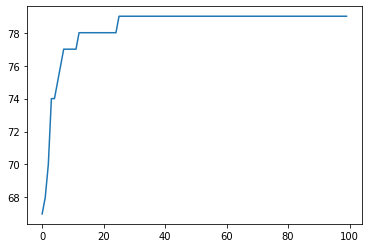

In [9]:
model_out.Happy.plot()

For testing purposes, here is a table giving each agent's x and y values at each step.

In [10]:
x_positions = model.datacollector.get_agent_vars_dataframe()
x_positions.head()

x  y
Step AgentID      
1    (0, 0)   9  7
     (0, 1)   8  3
     (0, 2)   3  9
     (0, 4)   6  0
     (0, 6)   2  1

# Effect of Homophily on segregation

Now, we can do a parameter sweep to see how segregation changes with homophily.

First, we create a function which takes a model instance and returns what fraction of agents are segregated -- that is, have no neighbors of the opposite type.

In [18]:
from mesa.batchrunner import batch_run

params = {"height": 10, "width": 10, "density": 0.8, "minority_pc": 0.2, 
              "homophily": [0.2, 0.4, 0.6, 0.8, 1.0]}

results = batch_run(
    SchellingModel,
    parameters=params,
    iterations=10,
    max_steps=200,
    number_processes=None,
    data_collection_period=1,
    display_progress=True,
)

5it [00:00, 10.52it/s]


ZeroDivisionError: division by zero

In [19]:
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'height', 'width', 'density',
       'minority_pc', 'homophily', 'Happy', 'Segregated_Agents', 'AgentID',
       'x', 'y'],
      dtype='object')


<AxesSubplot:title={'center':'Segregated_Agents'}, xlabel='homophily'>

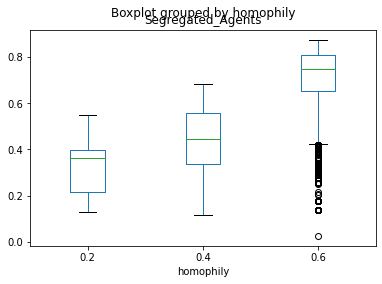

In [16]:
results_df.boxplot(by ='homophily', column =['Segregated_Agents'], grid=False)